In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

ads = pd.read_csv("impression_1M_53.csv")
ads = ads.sample(frac=1.0, random_state=5).reset_index(drop=True)
ads['user_answer_topic'] = ads.apply(compute_ratio, axis=1)

['user_id', 'answer_id', 'label', 'register_timestamp', 'gender', 'login_frequency', 'followers', 'topics_followed', 'questions_followed', 'answers', 'questions', 'comments', 'thanks_received', 'comments_received', 'likes_received', 'dislikes_received', 'register_type', 'register_platform', 'from_android', 'from_iphone', 'from_ipad', 'from_pc', 'from_mobile_web', 'device_model', 'device_brand', 'platform', 'province', 'city', 'user_topics', 'user_embedding', 'question_id', 'is_anonymous', 'author_id', 'is_high_value', 'is_editor_recommended', 'has_pictures', 'has_videos', 'thanks_count', 'likes_count', 'comments_count', 'collections_count', 'dislikes_count', 'reports_count', 'helpless_count', 'answer_topics', 'answer_vector', 'question_answer', 'question_follower', 'question_invitation', 'question_comments', 'is_excellent_author', 'author_follower_count', 'is_excellent_answerer']


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmeLU(nn.Module):
    """
    PyTorch ? Smooth ELU?SmeLU??????
    
    ???
      SmeLU(x) = ((x + beta)^2) / (4*beta),   if |x| <= beta
                = ReLU(x),                   otherwise
    ?? [-beta, beta] ??????????? ReLU ?????
    """
    def __init__(self, beta: float = 0.25):
        super().__init__()
        # beta ???????????????????? buffer ???????????
        self.register_buffer('beta', torch.tensor(beta))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        beta = self.beta
        # ????
        quad = ((x + beta) ** 2) / (4 * beta)
        # ReLU ??
        lin = F.relu(x)
        # ????
        return torch.where(x.abs() <= beta, quad, lin)
    def __repr__(self):
        return f"SmeLU(beta={float(self.beta):.4f})"
def compute_ratio(row):

    set_a = set(row['answer_topics'].split())
    set_b = set(row['user_topics'].split())
    
    if len(set_a) == 0:
        return 0  
    intersection_size = len(set_a & set_b)
    return intersection_size / len(set_a)


In [40]:



EMBED_DIM = 16
BATCH_SIZE = 512
EPOCHS = 20
LR = 0.0001

# cat_features = [
#     'user_id', 'answer_id', 'question_id', 'author_id',
#     'gender', 'register_type', 'register_platform',
#     'device_model', 'device_brand', 'platform',
#     'province', 'city',
#     'from_android', 'from_iphone', 'from_ipad',
#     'from_pc', 'from_mobile_web',
#     'is_anonymous', 'is_high_value', 'is_editor_recommended',
#     'has_pictures', 'has_videos',
#     'is_excellent_author', 'is_excellent_answerer'
# ]

# num_features = [
#     'register_timestamp', 'login_frequency',
#     'followers', 'topics_followed', 'questions_followed',
#     'answers', 'questions', 'comments',
#     'thanks_received', 'comments_received',
#     'likes_received', 'dislikes_received',
#     'thanks_count', 'likes_count', 'comments_count',
#     'collections_count', 'dislikes_count',
#     'reports_count', 'helpless_count',
#     'question_answer', 'question_follower',
#     'question_invitation', 'question_comments',
#     'author_follower_count','user_answer_topic'
# ]

cat_features = [
    'user_id', 'answer_id', 'question_id', 'author_id',
    'gender', 'register_type', 'register_platform',
    'device_model', 'device_brand', 
    'province', 'city',
    'is_high_value', 'is_editor_recommended',
    'is_excellent_author', 'is_excellent_answerer'
]

num_features = [
    'register_timestamp', 'login_frequency',
    'followers', 'topics_followed', 'questions_followed',
    'answers', 'questions', 'comments',
    'thanks_received', 'comments_received',
    'likes_received', 'dislikes_received',
    'likes_count', 'comments_count',
    'collections_count', 'dislikes_count',
    'question_answer', 'question_follower', 'question_comments',
    'author_follower_count','user_answer_topic'
]

for col in cat_features:
    ads[col] = LabelEncoder().fit_transform(ads[col].astype(str))

field_dims = [ads[col].nunique() for col in cat_features]
cross_idx = [0, 1]  # Placeholder indices; update based on actual interaction fields if needed

# Dummy answer vectors for demonstration purposes
# answer_vec = torch.randn(len(ads), 768)
ads['answer_vector'] = ads['answer_vector'] \
    .apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

ads['user_embedding'] = ads['user_embedding'] \
    .apply(lambda x: np.fromstring(x.strip('[]'), sep=' '))

answer_vec = torch.tensor(
    np.stack(ads['answer_vector'].values),
    dtype=torch.float32
)
user_vec = torch.tensor(
    np.stack(ads['user_embedding'].values),
    dtype=torch.float32
)



X_cat = torch.LongTensor(ads[cat_features].values)
X_num = torch.FloatTensor(ads[num_features].fillna(-1).values)
y = torch.FloatTensor(ads['label'].values)
# answer_vec = ads['answer_vector']  # Assuming provided or generated externally
# answer_vec = torch.tensor(np.stack(answer_vec.values), dtype=torch.float32)

# Train/Val/Test split
train_size = int(0.8 * len(ads))
val_size = int(0.1 * len(ads))
test_size = len(ads) - train_size - val_size

X_c_train, X_c_temp = torch.split(X_cat, [train_size, val_size + test_size])
X_n_train, X_n_temp = torch.split(X_num, [train_size, val_size + test_size])
y_train, y_temp = torch.split(y, [train_size, val_size + test_size])
vec_train, vec_temp = torch.split(answer_vec, [train_size, val_size + test_size])
user_vec_train, user_vec_temp = torch.split(user_vec, [train_size, val_size + test_size])

X_c_val, X_c_test = torch.split(X_c_temp, [val_size, test_size])
X_n_val, X_n_test = torch.split(X_n_temp, [val_size, test_size])
y_val, y_test = torch.split(y_temp, [val_size, test_size])
vec_val, vec_test = torch.split(vec_temp, [val_size, test_size])
user_vec_val, user_vec_test = torch.split(user_vec_temp, [val_size, test_size])

class RecDataset(Dataset):
    def __init__(self, cat, num, y, answer_vec,user_vec):
        self.cat, self.num, self.y, self.vec ,self.user_vec= cat, num, y, answer_vec,user_vec
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        return self.cat[i], self.num[i], self.y[i], self.vec[i], self.user_vec[i]

train_loader = DataLoader(RecDataset(X_c_train, X_n_train, y_train, vec_train,user_vec_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(RecDataset(X_c_val, X_n_val, y_val, vec_val,user_vec_val), batch_size=BATCH_SIZE)
test_loader = DataLoader(RecDataset(X_c_test, X_n_test, y_test, vec_test,user_vec_test), batch_size=BATCH_SIZE)




Epoch 1: Loss=0.5706, AUC=0.6181
Epoch 2: Loss=0.5615, AUC=0.6401
Epoch 3: Loss=0.5522, AUC=0.6546
Epoch 4: Loss=0.5443, AUC=0.6631
Epoch 5: Loss=0.5376, AUC=0.6691
Epoch 6: Loss=0.5313, AUC=0.6735
Epoch 7: Loss=0.5258, AUC=0.6756
Epoch 8: Loss=0.5210, AUC=0.6769
Epoch 9: Loss=0.5164, AUC=0.6800
Epoch 10: Loss=0.5115, AUC=0.6795
Epoch 11: Loss=0.5069, AUC=0.6765
Epoch 12: Loss=0.5026, AUC=0.6797
Epoch 13: Loss=0.4984, AUC=0.6783
Epoch 14: Loss=0.4939, AUC=0.6775
Epoch 15: Loss=0.4891, AUC=0.6749
Epoch 16: Loss=0.4844, AUC=0.6752
Epoch 17: Loss=0.4806, AUC=0.6745
Epoch 18: Loss=0.4759, AUC=0.6722
Epoch 19: Loss=0.4713, AUC=0.6707
Epoch 20: Loss=0.4669, AUC=0.6699

 Final Test AUC: 0.6656


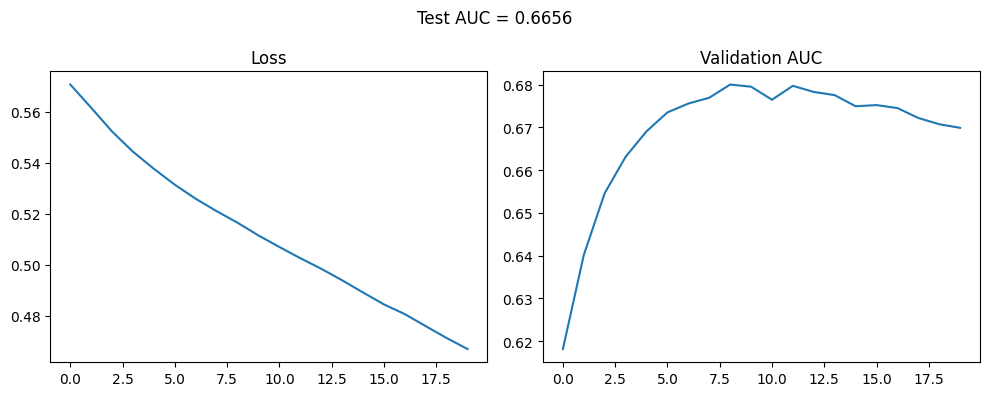

In [43]:
class FM(nn.Module):
    def forward(self, emb):
        square_sum = torch.sum(emb, dim=1)**2
        sum_square = torch.sum(emb**2, dim=1)
        return 0.5 * (square_sum - sum_square)

class DINDeepFM(nn.Module):
    def __init__(self, field_dims, cross_idx, emb_dim=EMBED_DIM , vec_dim=64,num_dim=len(num_features)):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(d, emb_dim) for d in field_dims])
        self.fm = FM()
        self.cross_idx = cross_idx
        # self.answer_proj = nn.Linear(vec_dim, emb_dim)
        self.mlp = nn.Sequential(
            # nn.Linear(emb_dim * len(field_dims) + emb_dim + 1, 128),
            # nn.Linear(emb_dim * len(field_dims) + emb_dim + len(num_features) + emb_dim, 128),
            nn.Linear((emb_dim * len(field_dims))+ len(num_features) + 2*vec_dim+vec_dim, 1024),
            SmeLU(), nn.Dropout(0.2),
            nn.Linear(1024, 512), SmeLU(), nn.Dropout(0.2), nn.Linear(512, 128),
            SmeLU(),nn.Linear(128, 1)
        )
        self.num_bn = nn.BatchNorm1d(num_dim)

    def forward(self, x_cat, x_num, answer_vec,user_vec):
        num_norm=self.num_bn(x_num)
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        fm_out = self.fm(torch.stack([embs[i] for i in self.cross_idx], dim=1))
        answer_vec = answer_vec.detach()
        user_vec = user_vec.detach()
        # fm_out = self.fm(torch.stack([*embs], dim=1))
        # fm_out_2= self.fm(torch.stack([num_norm], dim=1))
        # fm_out_3= self.fm(torch.stack([answer_vec,user_vec], dim=1))
        # final = torch.cat([*embs, fm_out, x_num, answer_vec], dim=1)
        final = torch.cat([*embs,num_norm,answer_vec,user_vec,answer_vec*user_vec], dim=1)
        return self.mlp(final).squeeze()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DINDeepFM(field_dims, cross_idx).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

losses, aucs = [], []
for epoch in range(EPOCHS):
    model.train(); total_loss = 0
    for xc, xn, yb, vec,user_vec in train_loader:
        xc, xn, yb, vec,user_vec = xc.to(device), xn.to(device), yb.to(device), vec.to(device),user_vec.to(device)
        pred = model(xc, xn, vec,user_vec)
        loss = criterion(pred, yb)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item()

    model.eval(); preds, labels = [], []
    with torch.no_grad():
        for xc, xn, yb, vec,user_vec in val_loader:
            xc, xn, vec ,user_vec = xc.to(device), xn.to(device), vec.to(device),user_vec.to(device)
            pred = model(xc, xn, vec,user_vec)
            preds.extend(torch.sigmoid(pred).cpu().numpy())
            labels.extend(yb.numpy())
    auc = roc_auc_score(labels, preds)
    print(f"Epoch {epoch+1}: Loss={total_loss/len(train_loader):.4f}, AUC={auc:.4f}")
    losses.append(total_loss / len(train_loader))
    aucs.append(auc)

model.eval(); test_preds, test_labels = [], []
with torch.no_grad():
    for xc, xn, yb, vec,user_vec in test_loader:
        xc, xn, vec ,user_vec= xc.to(device), xn.to(device), vec.to(device),user_vec.to(device)
        pred = model(xc, xn, vec,user_vec)
        test_preds.extend(torch.sigmoid(pred).cpu().numpy())
        test_labels.extend(yb.numpy())
test_auc = roc_auc_score(test_labels, test_preds)
print(f"\n Final Test AUC: {test_auc:.4f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.plot(losses); plt.title("Loss")
plt.subplot(1, 2, 2); plt.plot(aucs); plt.title("Validation AUC")
plt.suptitle(f"Test AUC = {test_auc:.4f}")
plt.tight_layout(); plt.show()

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.plot(losses); plt.title("Loss")
plt.subplot(1, 2, 2); plt.plot(aucs); plt.title("Validation AUC")
plt.suptitle(f"Test AUC = {test_auc:.4f}")
plt.tight_layout(); plt.show()